In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Single_User_IRS import Single_User
from Channel_Generation_2 import Channel_Generation as GCN
#from Channel_Generation import Generate_Channel as GC
from Channel_Genaration_3 import Channel_Generation as GC

In [2]:
def ZF_Beamforming(H_H, K, total_power):
    #W= H @ np.linalg.inv(H.conj().T @ H) 
    W= np.linalg.pinv(H_H)
    for k in range(K):
      W[:, k]= np.sqrt(total_power/K) * (W[:, k]/ np.linalg.norm(W[:, k]))
    signal_strength= np.abs(H_H @ W) **2
    sinr= np.zeros(K)
    wsr=0
    for k in range(K):
      rows= signal_strength[k, :]
      sinr[k]= rows[k]/ (np.sum(rows)-rows[k] + 1)
      wsr+= np.log2(1+sinr[k])
    return wsr

In [3]:
def compute_maximum_rate(K, M, N, total_power, ite):
    noise_power= 10**(-11)
    Avg_sum_rate_bar= np.zeros(ite)
    Avg_sum_rate_ZF= np.zeros(ite)
    for i in range(ite):
        rate_bar= np.zeros(K)
        theta= np.zeros((N, K), dtype= complex)
        
        CG= GC(K, M, N)
        Hd, Hr, G= CG.Generate_Channels()
        Hd, Hr= Hd/np.sqrt(noise_power), Hr/np.sqrt(noise_power)
        Hd_H, Hr_H= Hd.conj().T, Hr.conj().T
        
        SU= Single_User(K, M, N, 'power', total_power)
        for k in range(K):
            w, theta[:, k]= SU.Alternating_Optimization(Hd_H[k, :], Hr_H[k, :], G)
            rate_bar[k]= np.log2(1 + abs((Hd_H[k, :].reshape(1, -1) + Hr_H[k, :].reshape(1, -1) @ np.diag(theta[:, k]) @ G).flatten() @ w)**2)
        
        #print(rate_bar)
        k_hat= np.argmax(rate_bar)
        # print(k_hat + 1)
        H_H= Hd_H + Hr_H @ np.diag(theta[:, k_hat]) @ G
        sum_rate_ZF= ZF_Beamforming(H_H, K, total_power)
        Avg_sum_rate_bar[i]= rate_bar[k_hat]
        Avg_sum_rate_ZF[i]= sum_rate_ZF
    return np.mean(Avg_sum_rate_bar), np.mean(Avg_sum_rate_ZF)

In [4]:
K, M, N= 2, 8, 150
ite= 1000
power_dBm= range(-6, 13, 2)
Avg_Sum_Rate= np.zeros(len(power_dBm))
Avg_Sum_Rate_ZF= np.zeros(len(power_dBm))
for i, p in enumerate(power_dBm):
    total_power= 10**(p/10) * 0.001
    Avg_Sum_Rate[i], Avg_Sum_Rate_ZF[i]= compute_maximum_rate(K, M, N, total_power, ite)

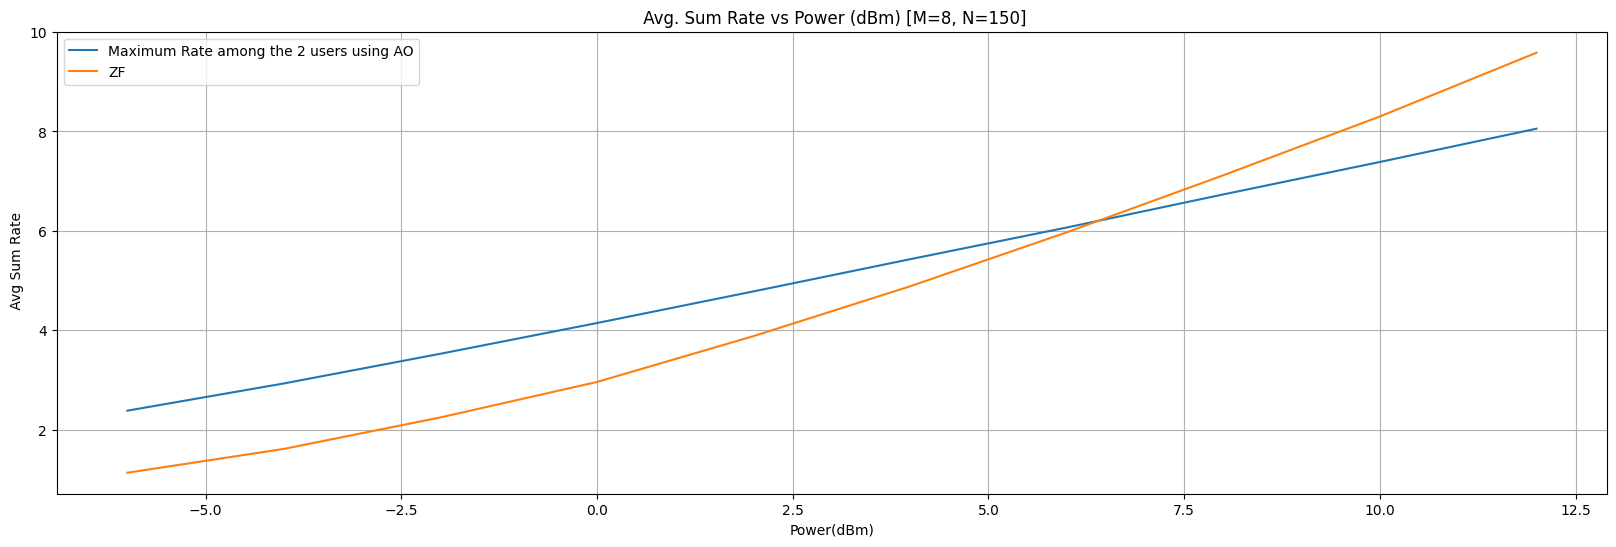

In [5]:
plt.figure(figsize=(20,6))
plt.plot(power_dBm,Avg_Sum_Rate,  label=f'Maximum Rate among the {K} users using AO')
plt.plot(power_dBm,Avg_Sum_Rate_ZF, label='ZF')

plt.title(f' Avg. Sum Rate vs Power (dBm) [M={M}, N={N}]')
plt.xlabel('Power(dBm)')
plt.ylabel(' Avg Sum Rate')
plt.grid(True)
plt.legend()
plt.show()
 # 

Zero Forcing

In [6]:
# for comparison with Non User Selection, M=8,N=150


avg_rate_zf_u1 = [0.18700782, 0.27759934, 0.42713398, 0.62428329, 0.91107365, 1.30528651, 1.82669709, 2.50258972, 3.30978977, 4.2401503 ]
avg_rate_zf_u2 = [0.18601417, 0.27961137, 0.4403855,  0.6595118,  0.96520669, 1.4340177, 1.98578147, 2.72715143, 3.6027465,  4.56794782]

Alternating Optimisation

In [7]:
# for comparison with non user selection: M=8, N=150

avg_rate_ao_u1 = [1.5730729,  2.04397249, 2.57294661, 3.14496838, 3.74127412, 4.37080416, 5.0103, 5.65479869, 6.31699886, 6.97097636]
avg_rate_ao_u2 = [1.51238094, 1.96782638, 2.49080798, 3.05930664, 3.66671203, 4.28198974, 4.91512912, 5.56720746, 6.21118874, 6.86368014]

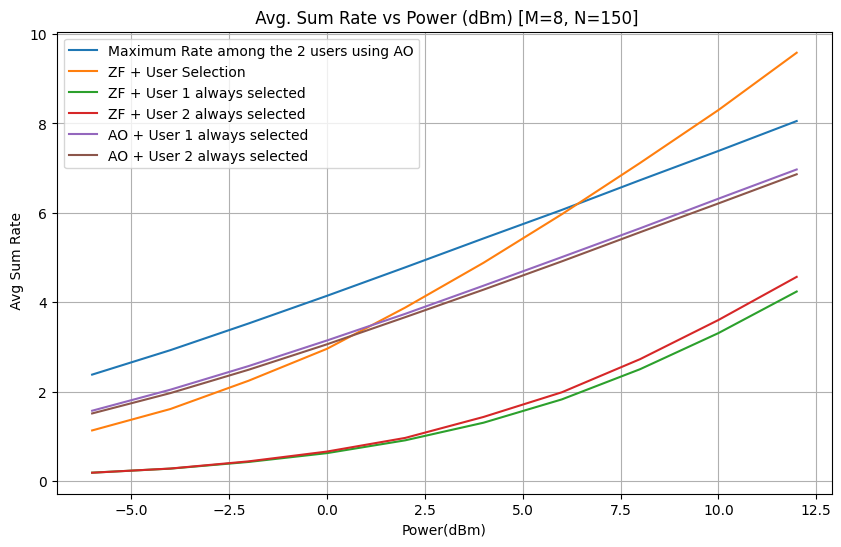

In [8]:
plt.figure(figsize=(10,6))
plt.plot(power_dBm,Avg_Sum_Rate,  label=f'Maximum Rate among the {K} users using AO')
plt.plot(power_dBm,Avg_Sum_Rate_ZF, label='ZF + User Selection')
plt.plot(power_dBm, avg_rate_zf_u1, label='ZF + User 1 always selected')
plt.plot(power_dBm, avg_rate_zf_u2, label='ZF + User 2 always selected')
plt.plot(power_dBm, avg_rate_ao_u1, label='AO + User 1 always selected')
plt.plot(power_dBm, avg_rate_ao_u2, label='AO + User 2 always selected')


plt.title(f' Avg. Sum Rate vs Power (dBm) [M={M}, N={N}]')
plt.xlabel('Power(dBm)')
plt.ylabel(' Avg Sum Rate')
plt.grid(True)
plt.legend()
plt.show()
 # 